# 2 ライブラリとデータ

## 2.1 ライブラリとデータ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
np.random.seed(1)

In [2]:
dataset = datasets.load_digits()
x = np.asarray(dataset.data)
t = np.asarray(dataset.target)

## 2.2 データの可視化

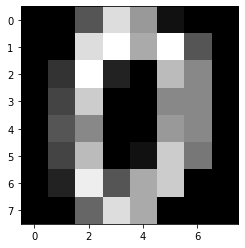

In [3]:
image = x[0,].reshape(8,8)
plt.imshow(image, cmap="binary_r")

In [4]:
t

array([0, 1, 2, ..., 8, 9, 8])

## 2.3 データの前処理

In [5]:
x = (x - np.average(x)) / np.std(x)

In [6]:
t_zero = np.zeros((len(t), 10))
for i in range(len(t_zero)):
    t_zero[i, t[i]] = 1

In [7]:
x_train, x_test, t_train, t_test = train_test_split(x, t_zero)

In [8]:
x_train.shape, x_test.shape, t_train.shape, t_test.shape

((1347, 64), (450, 64), (1347, 10), (450, 10))

# 3 モデル

In [9]:
class Optimizer:
    def step(self, lr):
        self.w -= lr * self.dw
        self.b -= lr * self.db

class Linear(Optimizer):
    def __init__(self, x_n, y_n):
        self.w = np.random.randn(x_n, y_n) * np.sqrt(2/x_n)
        self.b = np.zeros(y_n)
    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.w) + self.b
        return self.y
    def backward(self, dy):
        self.dw = np.dot(self.x.T, dy)
        self.db = np.sum(dy, axis=0)
        self.dx = np.dot(dy, self.w.T)
        return self.dx
    
class Relu:
    def forward(self, x):
        self.x = x
        y = np.where(self.x <= 0, 0, self.x)
        return y
    def backward(self, dy):
        dx =dy * np.where(self.x <= 0, 0, 1)
        return dx
    
class CELoss:
    def forward(self, x, t):
        self.t = t
        self.y = np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)  # ソフトマックス関数
        L = -np.sum(t*np.log(self.y+1e-7)) / len(self.y)
        return L
    def backward(self):
        dx = self.y - self.t
        return dx

In [10]:
def im2col(x, fil_size, y_size, stride, pad):
    x_b, x_c, x_h, x_w = x.shape
    fil_h, fil_w = fil_size, fil_size
    y_h, y_w = y_size, y_size
    index = -1
    
    x_pad = np.pad(x, [(0, 0), (0, 0), (pad, pad), (pad, pad)], "constant")
    x_col = np.zeros((fil_h*fil_w, x_b, x_c, y_h, y_w))
    
    for h in range(fil_h):
        h2 = h + y_h*stride
        for w in range(fil_w):
            index += 1
            w2 = w + y_w*stride
            x_col[index,:,:,:,:] = x_pad[:,:,h:h2:stride,w:w2:stride]
    x_col = x_col.transpose(2,0,1,3,4).reshape(x_c*fil_h*fil_w, x_b*y_h*y_w)
    
    return x_col

def col2im(dx_col, x_shape, fil_size, y_size, stride, pad):
    x_b, x_c, x_h, x_w = x_shape
    fil_h, fil_w = fil_size, fil_size
    y_h, y_w = y_size, y_size
    index = -1
    
    dx_col = dx_col.reshape(x_c, fil_h*fil_w, x_b, y_h, y_w).transpose(1,2,0,3,4)
    dx = np.zeros((x_b, x_c, x_h+2*pad+stride-1, x_w+2*pad+stride-1))
    
    for h in range(fil_h):
        h2 = h + y_h*stride
        for w in range(fil_w):
            index += 1
            w2 = w + y_w*stride
            dx[:,:,h:h2:stride,w:w2:stride] += dx_col[index,:,:,:,:]
    
    return dx[:,:,pad:x_h+pad, pad:x_w+pad]

In [11]:
class Conv(Optimizer):
    
    def __init__(self, x_c, y_c, fil_size, stride, pad):
        self.x_c, self.y_c = x_c, y_c
        self.fil_h, self.fil_w = fil_size, fil_size
        self.stride, self.pad = stride, pad
        
        self.w = np.random.randn(self.y_c, self.x_c, self.fil_h, self.fil_w)
        self.b = np.random.randn(1, self.y_c)
        
    def forward(self, x):
        self.xshape = x.shape
        self.x_b, self.x_c, self.x_h, self.x_w = x.shape
        self.y_h = (self.x_h - self.fil_h + 2*self.pad) // self.stride + 1
        self.y_w = (self.x_w - self.fil_w + 2*self.pad) // self.stride + 1
        self.y0 = im2col(x, self.fil_h, self.y_h, self.stride, self.pad)
        self.w_col = self.w.reshape(self.y_c, self.x_c*self.fil_h*self.fil_w)
        y = np.dot(self.w_col, self.y0).T + self.b
        self.y = y.reshape(self.x_b, self.y_h, self.y_w, self.y_c).transpose(0,3,1,2)
        return self.y
    
    def backward(self, dy):
        dy = dy.transpose(0,2,3,1).reshape(self.x_b*self.y_h*self.y_w, self.y_c)
        dw = np.dot(self.y0, dy)
        self.dw = dw.T.reshape(self.y_c, self.x_c, self.fil_h, self.fil_w)
        self.db = np.sum(dy, axis=0)
        dx = np.dot(dy, self.w_col)
        self.dx = col2im(dx.T, (self.xshape), self.fil_h, self.y_h, self.stride, self.pad)
        return self.dx
    
class Pooling:
    
    def __init__(self, pool):
        self.pool = pool
        
    def forward(self, x):
        self.xshape = x.shape
        self.x_b, self.x_c, self.x_h, self.x_w = x.shape
        self.y_h = self.x_h//self.pool if self.x_h%self.pool==0 else self.x_h//self.pool+1
        self.y_w = self.x_w//self.pool if self.x_w%self.pool==0 else self.x_w//self.pool+1
        x_col = im2col(x, self.pool, self.y_h, self.pool, 0).T.reshape(-1,self.pool*self.pool)
        y = np.max(x_col, axis=1)
        self.y = y.reshape(self.x_b, self.y_h, self.y_w, self.x_c).transpose(0,3,1,2)
        self.max_index = np.argmax(x_col, axis=1)
        return self.y
    
    def backward(self, dy):
        dy = dy.transpose(0,2,3,1)
        dx = np.zeros((self.pool*self.pool, dy.size))
        dx[self.max_index.reshape(-1), np.arange(dy.size)] = dy.reshape(-1)
        dx = dx.reshape(self.pool, self.pool, self.x_b, self.y_h, self.y_w, self.x_c)
        dx = dx.transpose(5,0,1,2,3,4)
        dx = dx.reshape(self.x_c*self.pool*self.pool, self.x_b*self.y_h*self.y_w)
        self.dx = col2im(dx, self.xshape, self.pool, self.y_h, self.pool, 0)
        return self.dx

In [12]:
conv = Conv(1, 8, 3, 1, 1)
relu1 = Relu()
pool = Pooling(2)
line1 = Linear(128, 64)
relu2 = Relu()
line2 = Linear(64, 10)
celoss = CELoss()

def model(x):
    y1 = conv.forward(x)
    y1 = relu1.forward(y1)
    y2 = pool.forward(y1)
    y3 = y2.reshape(x.shape[0],-1)
    y4 = line1.forward(y3)
    y4 = relu2.forward(y4)
    y5 = line2.forward(y4)
    return y5
def loss(y, t):
    L = celoss.forward(y, t)
    return L
def backward():
    dy5 = celoss.backward()
    dy4 = line2.backward(dy5)
    dy4 = relu2.backward(dy4)
    dy3 = line1.backward(dy4)
    dy2 = dy3.reshape(-1, 8, 4, 4)
    dy1 = pool.backward(dy2)
    dy1 = relu1.backward(dy1)
    dx = conv.backward(dy1)
def optimizer(lr):
    conv.step(lr)
    line1.step(lr)
    line2.step(lr)

# 4 モデルの学習

In [13]:
batch_size = 100
batch_n = len(x_train) // batch_size
batch_index = np.arange(len(x_train))

loss_train_all = []
loss_test_all = []

for epoch in range(1,100+1):
    np.random.shuffle(batch_index)
    for n in range(batch_n):
        mb_index = batch_index[n*batch_size:(n+1)*batch_size]
        y = model(x_train[mb_index].reshape(batch_size, 1, 8, 8))
        L = loss(y,t_train[mb_index])
        backward()
        optimizer(1e-3)
        
    y_train = model(x_train.reshape(-1, 1, 8, 8))
    loss_train = loss(y_train ,t_train)
    y_test = model(x_test.reshape(-1, 1, 8, 8))
    loss_test = loss(y_test ,t_test)
    
    loss_train_all.append(loss_train)
    loss_test_all.append(loss_test)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss_train {loss_train:.4f}, loss_test {loss_test:.4f}")

Epoch 10, loss_train 0.2572, loss_test 0.2794
Epoch 20, loss_train 0.1918, loss_test 0.1994
Epoch 30, loss_train 0.0601, loss_test 0.1353
Epoch 40, loss_train 0.0293, loss_test 0.1017
Epoch 50, loss_train 0.0223, loss_test 0.0976
Epoch 60, loss_train 0.0125, loss_test 0.0800
Epoch 70, loss_train 0.0088, loss_test 0.0811
Epoch 80, loss_train 0.0068, loss_test 0.0765
Epoch 90, loss_train 0.0054, loss_test 0.0743
Epoch 100, loss_train 0.0046, loss_test 0.0748


# 5 モデルの評価

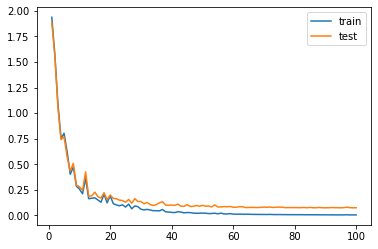

In [14]:
plt.plot(range(1,len(loss_train_all)+1), loss_train_all, label="train")
plt.plot(range(1,len(loss_test_all)+1), loss_test_all, label="test")
plt.legend()

In [15]:
def accuracy(x,t):
    acc = sum(model(x.reshape(len(x),1,8,8)).argmax(axis=1) == t.argmax(axis=1))/len(t)
    return acc

In [16]:
print(accuracy(x_train,t_train), accuracy(x_test,t_test))

1.0 0.9711111111111111
